In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
import pymc

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
df = pd.read_csv("/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv")

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

In [5]:
n = 1
dd = df[df["NbDealers"] == n + 1]

Y = dd["Y"].values
I = dd["TradeStatus"].values

In [6]:
mu_0, sigma_0 = 0, 10
shape_0, scale_0 = 1, 1
M = dd.shape[0]

mu_V = pymc.Normal('mu_V', mu_0, sigma_0, value=0)
sigma_V = pymc.InverseGamma('sigma_V', shape_0, scale_0, value=2)
V = pymc.Normal('V', mu_V, sigma_V, size=M)

mu_W = pymc.Normal('mu_W', mu_0, sigma_0, value=0)
sigma_W = pymc.Normal('sigma_W', shape_0, scale_0, value=2)
W = pymc.Normal('W', mu_W, sigma_W, size=(M, n))

@pymc.deterministic
def S(V=V, W=W, Y=Y):
    m = np.min(W, axis=1)
    idx_not_traded = np.minimum(m, Y) > V
    idx_traded_away = m <= Y
    idx_done = m > Y
    
    s = np.empty(V.shape[0], dtype=int)
    s[idx_done] = 2
    s[idx_traded_away] = 1
    s[idx_not_traded] = 0
    return s

def I_logp(value, S, p):
    diff = np.array(value == S, dtype=int)
    pp = (1 - p) * diff + p * (1 - diff)
    return sum(np.log(pp))

def I_random(S, p):
    b = bernoulli.rvs(p, size=S.shape[0])
    value = (S + b) % 3
    return value


II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0

flip = pymc.Stochastic( logp = I_logp,
                doc = 'Flip the observed value with probability p.',
                name = 'flip_real',
                parents = {'S': S, 'p': 0.01},
                random = I_random,
                trace = True,
                dtype=int,
                rseed = 1.,
                value = II,
                observed = True,
                plot=True,
                verbose = 0)

In [7]:
print S.value[:50]
print flip.value[:50]

[2 1 0 2 1 2 2 0 1 2 2 2 2 1 0 1 2 1 0 0 2 2 1 1 2 0 2 1 2 0 0 2 2 0 0 2 1
 0 2 2 1 2 2 2 0 0 1 2 1 2]
[2 2 0 2 0 2 0 0 0 2 1 0 0 0 0 2 2 1 0 0 0 2 0 1 0 0 2 2 0 0 0 2 2 1 0 0 2
 2 0 2 0 0 0 0 2 2 0 1 2 0]


In [8]:
print mu_V.value, sigma_V.value
print mu_W.value, sigma_W.value

0.0 2.0
0.0 2.0


In [9]:
model = pymc.Model([mu_V, sigma_V, V, mu_W, sigma_W, W, S, flip])

In [10]:
mcmc = pymc.MCMC(model)
mcmc.sample(10000, burn=0, thin=1)

 [-----------------100%-----------------] 10000 of 10000 complete in 34.7 sec

In [11]:
print mu_V.value, sigma_V.value
print mu_W.value, sigma_W.value

-0.00670972429229 1.99468368941
0.00998068775568 1.92268452073


In [12]:
mu_V_samples = mcmc.trace('mu_V')[:]
sigma_V_samples = mcmc.trace('sigma_V')[:]
mu_W_samples = mcmc.trace('mu_W')[:]
sigma_W_samples = mcmc.trace('sigma_W')[:]

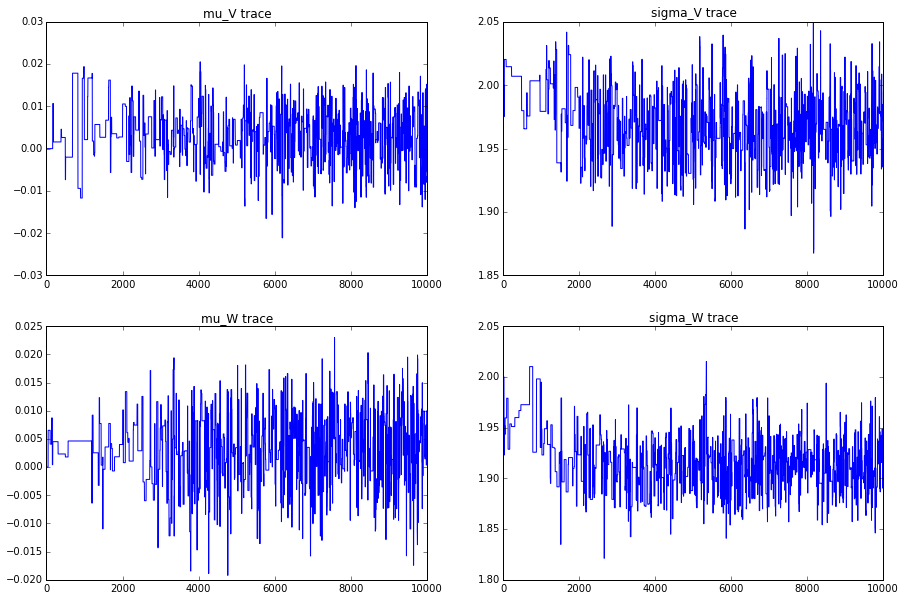

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(mu_V_samples)
plt.title("mu_V trace")
plt.subplot(2, 2, 2)
plt.plot(sigma_V_samples)
plt.title("sigma_V trace")

plt.subplot(2, 2, 3)
plt.plot(mu_W_samples)
plt.title("mu_W trace")
plt.subplot(2, 2, 4)
plt.plot(sigma_W_samples)
plt.title("sigma_W trace")

In [14]:
S.value[:100]

array([2, 1, 0, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 0, 1, 2, 1, 0, 0, 2, 2, 1,
       1, 2, 0, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0,
       1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 2,
       2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       0, 2, 0, 0, 2, 1, 1, 2])

In [15]:
flip.value[:100]

array([2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 2, 0,
       1, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2,
       0, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 1, 0])

(array([ 5495.,     0.,     0.,     0.,     0.,  2649.,     0.,     0.,
            0.,  4261.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

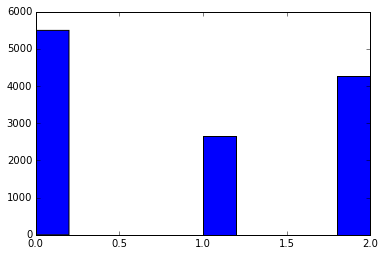

In [16]:
plt.hist(flip.value)

In [30]:
set(dd["TradeStatus"])

{'Done', 'NotTraded'}

In [29]:
set(flip)

{0, 2}